# Introduction to atomman: LAMMPS functionality

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

## 1. Introduction<a id='section1'></a>

This Notebook provides an introduction to interacting with LAMMPS using atomman by working through a demonstration simulation.

**Library Imports**

In [1]:
# Standard libraries
from pathlib import Path
import datetime

# http://www.numpy.org/
import numpy as np             

# http://matplotlib.org/
import matplotlib.pyplot as plt 
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am            
import atomman.lammps as lmp
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.7
Notebook executed on 2021-02-19


## 2. Interatomic Potential Control<a id='section2'></a>

LAMMPS is capable of using a wide array of interatomic potential styles, which are defined through a combination of LAMMPS commands and potential parameter files.  In atomman, the LAMMPS commands can be automatically generated using the Potentials class and structured data model files.

### 2.1. Load potential from database

Any LAMMPS-compatible potential in the NIST Interatomic Potentials Repository can be loaded/downloaded using load_lammps_potential().  

In [2]:
# Load potential based on its unique ID
pot_id = '2015--Pascuet-M-I--Al--LAMMPS--ipr1'
potential = am.load_lammps_potential(pot_id, getfiles=True)

### 2.2. Potential parameter files

Setting getfiles=True will copy/download the potential parameter files from the local/remote library database to the current working directory in a subfolder matching the potential's id.

In [3]:
for fname in Path(pot_id).glob('*'):
    print(fname)
    with open(fname) as f:
        print(f.read())
    print()

2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam
re(1,1) =   2.86378
attrac(1,1) = 0.39558
repuls(1,1) = 0.09806
Cmin(1,1,1) = 1.00769
Cmax(1,1,1) = 2.31407
#
rc = 5.0
delr = 0.1
augt1 = 1


2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam
# References:
# elt        lat     z       ielement     atwt
# alpha      b0      b1      b2           b3    alat    esub    asub
# t0         t1              t2           t3            rozero  ibar
#
'Al'        'fcc'   12.     13           26.9815
  4.68604   1.56205   5.39270   5.29601  -1.00047   4.05000   3.35999   1.06859
1.0  -1.54917  -1.28508  10.01041 1.0 0 




### 2.3. lammps.Potential Class

The load_lammps_potential() function returns a Potential object that can be used to explore properties of the potential and generate LAMMPS input commands.

Basic properties can be directly obtained.

In [4]:
# Show that basic properties can be directly obtained
print('str(potential) ->       ', potential)
print('potential.units ->      ', potential.units)
print('potential.atom_style -> ', potential.atom_style)
print('potential.pair_style -> ', potential.pair_style)
print('potential.symbols ->    ', potential.symbols)
print('potential.elements() -> ', potential.elements())
print('potential.masses() ->   ', potential.masses())

str(potential) ->        2015--Pascuet-M-I--Al--LAMMPS--ipr1
potential.units ->       metal
potential.atom_style ->  atomic
potential.pair_style ->  meam
potential.symbols ->     ['Al']
potential.elements() ->  ['Al']
potential.masses() ->    [26.9815]


The LAMMPS command lines for the potential are auto-generated based on a list of symbols corresponding to LAMMPS atom types. This fully works for all LAMMPS pair_styles, with only the hybrid and hybrid/overlay styles having limitations.

In [5]:
print('potential.pair_info() ->')
print(potential.pair_info())

potential.pair_info() ->
mass 1 26.9815

pair_style meam
pair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam Al



In [6]:
print("potential.pair_info(['Al', 'Al', 'Al']) ->")
print(potential.pair_info(['Al', 'Al', 'Al']))

potential.pair_info(['Al', 'Al', 'Al']) ->
mass 1 26.9815
mass 2 26.9815
mass 3 26.9815

pair_style meam
pair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam Al Al Al



## 3. Generate initial system<a id='section3'></a>

### 3.1. Load relaxed crystal 

A crystalline system can be easily generated using a unit cell system either defined in atomman, imported from another format, or accessed from the potentials database.  For simplicity, here we will get the relaxed fcc structure for the potential.

Load fcc prototype with Al lattice constant

In [7]:
system = am.load('crystal', family='A1--Cu--fcc', potential=potential)
print(system)

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
symbols = ('Al',)
pbc = [ True  True  True]
per-atom properties = ['atype', 'pos']
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   2.025 |   2.025
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   2.025 |   2.025 |   0.000


### 3.2. Manipulate system

More complicated atomic configurations can then be generated by manipulating the seed system and the atoms contained within. Here, we'll limit the manipulations to making the system a 3x3x3 supercell of itself.

In [8]:
system = system.supersize(3,3,3)
print('Supercell has', system.natoms, 'atoms')

Supercell has 108 atoms


### 3.3. Save to atom data file

System.dump('atom_data') outputs the system to a LAMMPS atom data file. Quick notes on the parameters used here

- Giving potential allows for the appropriate units and atom_style settings to be used.
- The float_format value used here is a small precision to enhance clarity of print statements below. Typically, the precision should be large (default value is '%.13f').
- Setting return_pair_info=True will return the LAMMPS commands for both the system and the potential together.  This is the preferred method as it ensures compatibility with all potential pair styles currently in the database.

In [9]:
# Save System to 'atom.dat' atom data file 
system_pair_info = system.dump('atom_data', f='atom.dat',
                          potential=potential,
                          float_format='%.4f',    # Remove or make larger precision for real runs!
                          return_pair_info=True)

Show the returned LAMMPS command lines

In [10]:
print(system_pair_info)

# Script and atom data file prepared using atomman Python package

units metal
atom_style atomic

boundary p p p
read_data atom.dat

mass 1 26.9815

pair_style meam
pair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam Al



Show the contents of the data file

In [11]:
with open('atom.dat') as f:
    print(f.read())


108 atoms
1 atom types
0.0000 12.1500 xlo xhi
0.0000 12.1500 ylo yhi
0.0000 12.1500 zlo zhi

Atoms # atomic

1 1 0.0000 0.0000 0.0000
2 1 0.0000 2.0250 2.0250
3 1 2.0250 0.0000 2.0250
4 1 2.0250 2.0250 0.0000
5 1 4.0500 0.0000 0.0000
6 1 4.0500 2.0250 2.0250
7 1 6.0750 0.0000 2.0250
8 1 6.0750 2.0250 0.0000
9 1 8.1000 0.0000 0.0000
10 1 8.1000 2.0250 2.0250
11 1 10.1250 0.0000 2.0250
12 1 10.1250 2.0250 0.0000
13 1 0.0000 4.0500 0.0000
14 1 0.0000 6.0750 2.0250
15 1 2.0250 4.0500 2.0250
16 1 2.0250 6.0750 0.0000
17 1 4.0500 4.0500 0.0000
18 1 4.0500 6.0750 2.0250
19 1 6.0750 4.0500 2.0250
20 1 6.0750 6.0750 0.0000
21 1 8.1000 4.0500 0.0000
22 1 8.1000 6.0750 2.0250
23 1 10.1250 4.0500 2.0250
24 1 10.1250 6.0750 0.0000
25 1 0.0000 8.1000 0.0000
26 1 0.0000 10.1250 2.0250
27 1 2.0250 8.1000 2.0250
28 1 2.0250 10.1250 0.0000
29 1 4.0500 8.1000 0.0000
30 1 4.0500 10.1250 2.0250
31 1 6.0750 8.1000 2.0250
32 1 6.0750 10.1250 0.0000
33 1 8.1000 8.1000 0.0000
34 1 8.1000 10.1250 2.0250
35 1 1

## 4. Converting to/from LAMMPS units<a id='section4'></a>

LAMMPS performs its calculations with values in one of multiple sets of pre-defined units.  The atomman.lammps.style submodule has some useful functions when working with different units options.

**atomman.lammps.style.timestep()**

The lammps.style.timestep() function returns the default timestep value for a given LAMMPS units option.

Parameters

- **units** (*str*) the LAMMPS units option being used.

**atomman.lammps.style.unit()**

The lammps.style.unit() function returns a dictionary giving the units associated with physical quantities as used by LAMMPS with a given units option.

Parameters

- **units** (*str*) the LAMMPS units option being used.

In [12]:
timestep = lmp.style.timestep(potential.units)
print(timestep)

0.001


In [13]:
lammps_unit = lmp.style.unit(potential.units)
print(lammps_unit)

OrderedDict([('mass', 'g/mol'), ('length', 'angstrom'), ('time', 'ps'), ('energy', 'eV'), ('velocity', 'angstrom/ps'), ('force', 'eV/angstrom'), ('torque', 'eV'), ('temperature', 'K'), ('pressure', 'bar'), ('dynamic viscosity', 'Pa*s/10'), ('charge', 'e'), ('dipole', 'e*angstrom'), ('electric field', 'V/angstrom'), ('density', 'g/cm^3'), ('ang-mom', 'angstrom*angstrom/ps*g/mol'), ('ang-vel', '1/ps')])


## 5. Composing LAMMPS Input Scripts<a id='section5'></a>

LAMMPS scripts can easily be constructed by combining the system_info generated from System.dump('atom_data'), the pair_info from Potential.pair_info(), and any user-defined input lines.  This allows for specific simulation actions to easily be perfored across different potentials or initial configurations.

### 5.1. Show content generated in previous sections

Show system_pair_info generated in Section 3.3.

In [14]:
print(system_pair_info)

# Script and atom data file prepared using atomman Python package

units metal
atom_style atomic

boundary p p p
read_data atom.dat

mass 1 26.9815

pair_style meam
pair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam Al



### 5.2. Write LAMMPS input script template

LAMMPS scripts can be dynamically generated using Python functions or templates that take the above info lines and other values as parameters. Here, we demonstrate a LAMMPS input template script where all fields to be filled in in Python are delimited with <> brackets.

In [15]:
template = """
<system_pair_info>

# Define temperature and dependent variables
variable T equal <temperature>
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal <pressure>

# Define timestep and dependent variables
variable deltat equal <timestep>
variable Trelax equal 100*${deltat}
variable Prelax equal 1000*${deltat}

# Initialize atomic velocities with twoT
velocity all create ${twoT} 124352

# Define thermo steps and properties
thermo 100
thermo_style custom step temp press lx ly lz

# Define dump 
dump mydump all atom 100000 *.dump

# Specify timestep
timestep ${deltat}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}

# Run simulation
run 100000
"""           

### 5.3. Fill in the template with atomman.tools.filltemplate()

The template can then be easily filled in with the atomman.tools.filltemplate() function. 

Parameters

- **template** (*str or file-like object*) is the template to fill in.

- **variable** (*dict*) gives the delimited keys and corresponding values to insert into the template.

- **s_delimiter** (*str*) the starting delimiter for identifying variable names.

- **e_delimiter** (*str*) the ending delimiter for identifying variable names.

Build dictionary of template variables

In [16]:
lammps_variable = {}

# Generated above
lammps_variable['system_pair_info'] = system_pair_info

# Set timestep to default value for LAMMPS units
lammps_variable['timestep'] = lmp.style.timestep(units=potential.units)

# Specify temperature to equilibriate at (always in Kelvin)
lammps_variable['temperature'] = 100

# Specify pressure to equilibriate at
pressure = uc.set_in_units(0.0, 'MPa')
lammps_variable['pressure'] = uc.get_in_units(pressure, lammps_unit['pressure'])

print(lammps_variable)

{'system_pair_info': '# Script and atom data file prepared using atomman Python package\n\nunits metal\natom_style atomic\n\nboundary p p p\nread_data atom.dat\n\nmass 1 26.9815\n\npair_style meam\npair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\\Al.meam Al\n', 'timestep': 0.001, 'temperature': 100, 'pressure': 0.0}


Fill in template

In [17]:
# Generate script from template and lammps_variable
script = am.tools.filltemplate(template, lammps_variable, '<', '>')

# Save script to 'nvt.in'
with open('nvt.in', 'w') as f:
    f.write(script)

# Show contents of 'nvt.in'    
with open('nvt.in') as f:
    print(f.read())


# Script and atom data file prepared using atomman Python package

units metal
atom_style atomic

boundary p p p
read_data atom.dat

mass 1 26.9815

pair_style meam
pair_coeff * * 2015--Pascuet-M-I--Al--LAMMPS--ipr1\library-Al.meam Al 2015--Pascuet-M-I--Al--LAMMPS--ipr1\Al.meam Al


# Define temperature and dependent variables
variable T equal 100
variable twoT equal 2*$T

# Define equilibrium pressure
variable P equal 0.0

# Define timestep and dependent variables
variable deltat equal 0.001
variable Trelax equal 100*${deltat}
variable Prelax equal 1000*${deltat}

# Initialize atomic velocities with twoT
velocity all create ${twoT} 124352

# Define thermo steps and properties
thermo 100
thermo_style custom step temp press lx ly lz

# Define dump 
dump mydump all atom 100000 *.dump

# Specify timestep
timestep ${deltat}

# Apply npt conditions
fix 1 all npt temp $T $T ${Trelax} iso $P $P ${Prelax}

# Run simulation
run 100000



## 6. Run LAMMPS<a id='section6'></a>

The LAMMPS simulation can be ran from within Python using the run() function.

Specify your lammps executable

In [18]:
lammps_exe = 'lmp_serial'

Run the simulation 

In [19]:
output = lmp.run(lammps_exe, 'nvt.in')

The resulting simulation data is returned as a Log object, which containes the thermo data from the log.lammps files. 

## 7. Analyzing Thermo Results<a id='section7'></a>

Data for each simulation run/minimization is stored in the returned Log object.  Each Simulation has a thermo property that is a pandas.DataFrame of the LAMMPS thermo data.

*Updated version 1.3.7*: Each simulation is now represented using a Simulation class rather than a dictionary.

Show thermo data column names for the first (and only) simulation run.

In [20]:
print(list(output.simulations[0].thermo.keys()))

['Step', 'Temp', 'Press', 'Lx', 'Ly', 'Lz']


For backwards compatibility, the thermo can also be accessed as if the simulation was still a dictionary.

In [21]:
print(list(output.simulations[0]['thermo'].keys()))

['Step', 'Temp', 'Press', 'Lx', 'Ly', 'Lz']


Plot temperature vs. run step

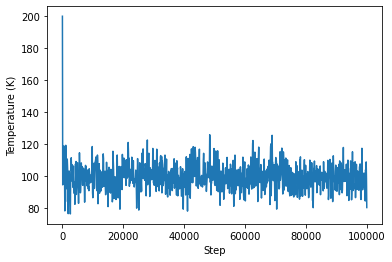

In [22]:
# Pull out data
steps = output.simulations[0].thermo.Step
temps = output.simulations[0].thermo.Temp

# Plot
plt.plot(steps, temps)
plt.xlabel('Step')
plt.ylabel('Temperature (K)')
plt.show()

Plot pressure vs. run step (note unit conversions)

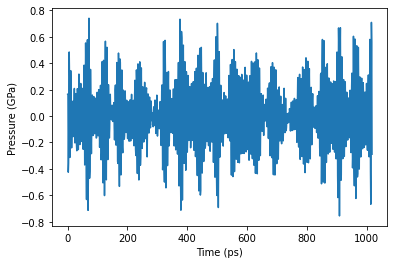

In [23]:
# Convert steps to time in atomman working units
steps = output.simulations[0].thermo.Step
time = uc.set_in_units(timestep, lammps_unit['time']) * steps

# Convert press to atomman working units
press = uc.set_in_units(output.simulations[0].thermo.Press, lammps_unit['pressure'])

# Plot in ps and GPa
plt.plot(uc.get_in_units(steps, 'ps'), uc.get_in_units(press, 'GPa'))
plt.xlabel('Time (ps)')
plt.ylabel('Pressure (GPa)')
plt.show()

## 8 Reading in dump files <a id='section8'></a>

Finally, any dump files generated by the LAMMPS simulation can be loaded into atomman as Systems.  

In [24]:
system = am.load('atom_dump', '100000.dump', symbols='Al')
print(system.box)
system.atoms_df()

avect =  [12.191,  0.000,  0.000]
bvect =  [ 0.000, 12.191,  0.000]
cvect =  [ 0.000,  0.000, 12.191]
origin = [-0.021, -0.021, -0.021]


,atype,pos[0],pos[1],pos[2],atom_id
0,1,0.003687,-0.060490,-0.023425,1
1,1,-0.054033,2.032270,1.997684,2
2,1,2.055068,0.018910,1.980677,3
3,1,1.997684,2.080987,-0.002075,4
4,1,4.081188,0.036592,-0.051009,5
...,...,...,...,...,...
103,1,6.042340,10.090836,8.060340,104
104,1,8.037871,8.044527,8.075286,105
105,1,8.068666,10.122228,10.109220,106
106,1,10.135773,8.173499,10.091238,107


**File Cleanup**

In [25]:
for fname in Path(pot_id).glob('*'):
    fname.unlink()
Path(pot_id).rmdir()
Path('atom.dat').unlink()
Path('nvt.in').unlink()
Path('log.lammps').unlink()

for fname in Path('.').glob('*.dump'):
    fname.unlink()